In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [7]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = True
overlap_thr= 0

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print('making dirs')
print(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single


## Output dirs

In [8]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
curr_dst_dir = os.path.join(basedir, 'controls', 'match_rfs')

if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs
dff-ROC__stimulus__matchRF__C1.00


## Check input data

In [9]:
import _pickle as pkl
input_id = '__'.join(aggr_id.split('__')[0:-1])
input_files = glob.glob(os.path.join(basedir, 'files', 
                                     'inputcells-*_%s.pkl' % input_id))
#input_files = glob.glob(os.path.join(basedir, 'files', 'inputcells*.pkl'))
print(len(input_files))
#input_fpath = input_files[0]
i_=[]
for ipath in input_files:
    with open(ipath, 'rb') as f:
        icells = pkl.load(f)
    i_.append(icells)
inputcells = pd.concat(i_, axis=0)

3


In [10]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

<IPython.core.display.Javascript object>


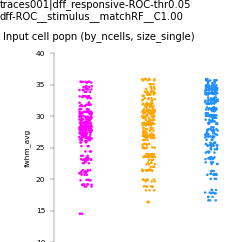

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs input_cell_distribution__dff-ROC__stimulus__matchRF__C1.00


In [11]:
fig, ax = pl.subplots(figsize=(3,3))

sns.stripplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, s=2,
              palette=area_colors, order=visual_areas, zorder=-1000)
# sns.pointplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='k', order=visual_areas, scale=0.5, errwidth=0.5, join=False,
#              markers='_', zorder=1000, ci='sd', estimator=np.median)
ax.set_ylim((10, 40))
pl.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
# sns.boxplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='w', order=visual_areas, fliersize=0)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
fig.text(0.01, 0.85, 'Input cell popn (%s, %s)' % (analysis_type, test_type), 
         fontsize=8)
figname = 'input_cell_distribution__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [12]:
aggr_id

'dff-ROC__stimulus__matchRF__C1.00'

## Load

In [13]:
max_ncells = 96 #96 # if match_rfs and (responsive_test=='ROC')
special_cases = [169, 120, 46]
experiment = 'gratings' if class_name=='ori' else 'blobs'
i_=[]
for match_rf_flag in [True, False]:
    iterdf_, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=None,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rf_flag, 
                          overlap_thr=0 if match_rf_flag is False else None)

    sample_sizes = [s for s in sorted(iterdf_['n_cells'].unique()) if s <=max_ncells\
                   and s not in special_cases]
    iterdf_ = iterdf_[iterdf_['n_cells'].isin(sample_sizes)]
    iterdf_['rfs'] = 'matched' if match_rf_flag else 'all'
    iterdf_['match_rfs'] = match_rf_flag
    i_.append(iterdf_)
iterdf = pd.concat(i_, axis=0, ignore_index=True) #.dropna()

(Li) Found 8 paths
(Lm) Found 8 paths
(V1) Found 8 paths
(Li) Found 10 paths
(Lm) Found 10 paths
(V1) Found 11 paths


In [14]:
    
m_=[]
for rf_cond, iterdf_ in iterdf.groupby('rfs'):
    # Group means
    grouper = ['visual_area', 'condition', 'iteration']
    mean_ = dec.average_within_iterations_by_ncells(iterdf_, 
                                analysis_type=analysis_type, test_type=test_type,
                                grouper=grouper) 
    mean_['rfs'] = rf_cond
    #mean_['match_rfs'] = match_rf_flag
    m_.append(mean_)
mean_df = pd.concat(m_, axis=0).reset_index(drop=True)

In [15]:
n_iters = iterdf['iteration'].max() +1
xlabels = [1, 32, 64, 96, max_ncells]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("rfs:", mean_df['rfs'].unique(), mean_df['match_rfs'].unique())

mean_df['novel_labels'] = None
mean_df.loc[mean_df['novel'], 'novel_labels'] = 'novel'
mean_df.loc[~mean_df['novel'], 'novel_labels'] = 'trained'

novel: [False  True]
conditions: ['data' 'shuffled']
rfs: ['all' 'matched'] [False  True]


In [16]:
mean_df.groupby(['visual_area', 'condition', 'train_transform', 'test_transform', 'novel', 'rfs', 'n_cells']).count()

iteration  \
visual_area condition train_transform test_transform novel rfs     n_cells              
Li          data      30.0            30.0           False all     1              500   
                                                                   2              500   
                                                                   4              500   
                                                                   8              500   
                                                                   16             500   
...                                                                               ...   
V1          shuffled  30.0            30.0           False matched 8              500   
                                                                   16             500   
                                                                   32             500   
                                                                   64             500   
                                                                   96             500   

                                                                            fit_time  \
visual_area condition train_transform test_transform novel rfs     n_cells             
Li          data      30.0            30.0           False all     1             500   
                                                                   2             500   
                                                                   4             500   
                                                                   8             500   
                                                                   16            500   
...                                                                              ...   
V1          shuffled  30.0            30.0           False matched 8             500   
                                                                   16            500   
                                                                   32            500   
                                                                   64            500   
                                                                   96            500   

                                                                            score_time  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1               500   
                                                                   2               500   
                                                                   4               500   
                                                                   8               500   
                                                                   16              500   
...                                                                                ...   
V1          shuffled  30.0            30.0           False matched 8               500   
                                                                   16              500   
                                                                   32              500   
                                                                   64              500   
                                                                   96              500   

                                                                            test_score  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1               500   
                                                                   2               500   
                                                                   4               500   
                                                                   8               500   
                                                              

In [17]:
print_index = ['visual_area','rfs', 'novel']

if test_type is not None:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'novel', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=print_index, columns='n_cells')
else:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area'], columns='n_cells')
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: blobs (class=morphlevel): dff-ROC__stimulus__matchRF__C1.00


heldout_test_score                                \
n_cells                                   1         2         4         8    
visual_area rfs     novel                                                    
Li          all     False           0.525020  0.544831  0.570656  0.598471   
                    True            0.523391  0.537498  0.556059  0.582581   
            matched False           0.535555  0.555703  0.585391  0.607603   
                    True            0.536457  0.547944  0.571630  0.593906   
Lm          all     False           0.534767  0.545600  0.561500  0.589667   
                    True            0.517668  0.522439  0.531990  0.541983   
            matched False           0.529367  0.538167  0.555733  0.578900   
                    True            0.520351  0.527039  0.538333  0.554007   
V1          all     False           0.542438  0.560095  0.589200  0.619867   
                    True            0.520938  0.532741  0.551360  0.564369   
            matched False           0.549390  0.573081  0.612667  0.650567   
                    True            0.528450  0.538147  0.560299  0.580308   

                                                                   
n_cells                          16        32        64        96  
visual_area rfs     novel                                          
Li          all     False  0.615770  0.645717  0.724856  0.772612  
                    True   0.598081  0.623237  0.674318  0.707698  
            matched False  0.643817  0.682259  0.765552  0.812609  
                    True   0.626433  0.654182  0.713580  0.747681  
Lm          all     False  0.614267  0.640900  0.702533  0.743033  
                    True   0.552917  0.563745  0.595391  0.614047  
            matched False  0.594600  0.624233  0.676500  0.705933  
                    True   0.565181  0.579734  0.612484  0.640829  
V1          all     False  0.653233  0.694700  0.768233  0.815267  
                    True   0.583514  0.606193  0.648800  0.678997  
            matched False  0.690100  0.728733  0.815833  0.853033  
                    True   0.607134  0.634751  0.681319  0.712993

In [18]:
area_colors2 = {'V1': 'darkmagenta', 'Lm': 'saddlebrown', 'Li': 'darkblue'}

In [19]:
pl.rcParams['legend.title_fontsize'] = 8


<IPython.core.display.Javascript object>


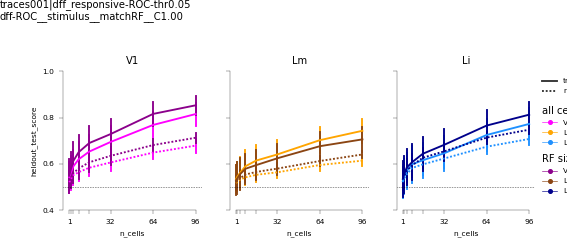

2 [<matplotlib.lines.Line2D object at 0x2af1b5d47810>, <matplotlib.lines.Line2D object at 0x2af1b5d47590>, <matplotlib.lines.Line2D object at 0x2af1b5db2f50>, <matplotlib.lines.Line2D object at 0x2af1b5e4cdd0>]
1 [<matplotlib.lines.Line2D object at 0x2af1b5eb3e50>, <matplotlib.lines.Line2D object at 0x2af1b5ec0590>, <matplotlib.lines.Line2D object at 0x2af1b5ec0c90>, <matplotlib.lines.Line2D object at 0x2af1b5eca3d0>]
2
0 [<matplotlib.lines.Line2D object at 0x2af1b5eca950>, <matplotlib.lines.Line2D object at 0x2af1b5e8ff10>, <matplotlib.lines.Line2D object at 0x2af1b5e8fb10>, <matplotlib.lines.Line2D object at 0x2af1b5d41750>]
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs accuracy_byncell_curves_matchRF-v-all_train-v-novel


In [20]:
metric='heldout_test_score'

plotd = mean_df[mean_df.condition=='data']

#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)

for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]; ax.set_title(va);
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='all'], ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors[va])
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='matched'],ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors2[va])
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.set_ylim([0.4, 1])
    print(ai, ax.legend_.legendHandles)
    if ai==1:
        leg_h = ax.legend_.legendHandles[0:2]
        print(len(leg_h))
        leg = ax.legend(handles=leg_h, bbox_to_anchor=(2.2,1.), loc='upper left', 
                  frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.legend_.remove()
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_box_aspect(1)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

leg_h2 = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[-1].legend(handles=leg_h2, bbox_to_anchor=(1,0.8), loc='upper left', 
               frameon=False, title='all cells')
leg._legend_box.align = "left"

leg_h3 = pplot.custom_legend_markers(colors=[area_colors2[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[0].legend(handles=leg_h3, bbox_to_anchor=(3.4,0.45), loc='upper left', 
               frameon=False, title='RF size-matched', fontsize=6)
leg._legend_box.align = "left"

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, wspace=0.2, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'accuracy_byncell_curves_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [21]:
import itertools
max_ncells

96

In [22]:
plotd = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]
plotd.head()


,visual_area,condition,iteration,n_cells,novel,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,train_transform,test_transform,n_trials,randi_cells,intact,match_rfs,rfs,novel_labels
14,Li,data,0,96,False,0.045807,0.000376,0.866667,1.0,0.700000,1.0,5157.4,30.0,30.0,38.0,9286.0,True,False,all,trained
15,Li,data,0,96,True,0.045807,0.000376,0.866667,1.0,0.700000,1.0,5157.4,30.0,30.0,38.0,9286.0,True,False,all,novel
30,Li,data,1,96,False,0.000752,0.000299,0.753333,1.0,0.775000,1.0,5587.6,30.0,30.0,38.0,287.0,True,False,all,trained
31,Li,data,1,96,True,0.000752,0.000299,0.753333,1.0,0.707895,1.0,5587.6,30.0,30.0,38.0,287.0,True,False,all,novel
46,Li,data,2,96,False,0.000739,0.000299,0.780000,1.0,0.875000,1.0,4615.4,30.0,30.0,38.0,2775.0,True,False,all,trained


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


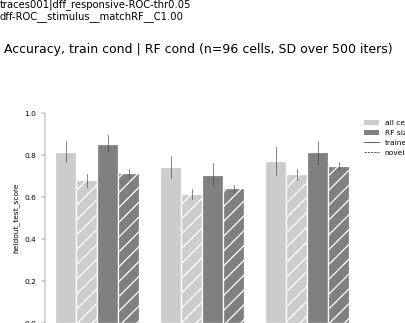

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [23]:
%matplotlib notebook
plotd['plotcond'] = ['%s_%s' %  (r, n) for r, n in plotd[['rfs', 'novel_labels']].values]

matchrf_color = [0.5]*3
all_color = [0.8]*3
plot_palette = {'all_trained': all_color, 'all_novel': all_color,
                'matched_trained': matchrf_color, 'matched_novel': matchrf_color}
keys = ['all_trained', 'all_novel', 'matched_trained', 'matched_novel']

fig, ax = pl.subplots(figsize=(5,4))
sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
           hue='plotcond', hue_order=keys, palette=plot_palette, 
           edgecolor='w', order=visual_areas, ci='sd', errwidth=0.5)
# legends
leg_h = pplot.custom_legend_markers(colors=[all_color, matchrf_color],
                                    labels=['all cells', 'RF size-matched'],
                                    use_patch=True)
leg_h2 = pplot.custom_legend_markers(colors=['k', 'k'],
                                    labels=['trained', 'novel'],markers=None,
                                    linestyles=['-', '--'], use_patch=False)
ax.legend(handles=leg_h+leg_h2, bbox_to_anchor=(0.99,1), 
          loc='upper left', frameon=False)

bar_locs = 3
hatches = itertools.cycle(['', '//'])
for i, bar in enumerate(ax.patches):
    if i % bar_locs == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_aspect(2, anchor='SW')
ax.set_ylim([0, 1])
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
fig.text(0.01, 0.85,\
         'Accuracy, train cond | RF cond (n=%i cells, SD over %i iters)' \
         % (max_ncells, n_iters))

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'compare_performance_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [24]:
data_ = mean_df[(mean_df['n_cells']==max_ncells) 
            & (mean_df['condition']=='data')].copy().reset_index(drop=True)
data_.groupby(['visual_area', 'novel', 'rfs']).count()

condition  iteration  n_cells  fit_time  \
visual_area novel rfs                                                
Li          False all            500        500      500       500   
                  matched        500        500      500       500   
            True  all            500        500      500       500   
                  matched        500        500      500       500   
Lm          False all            500        500      500       500   
                  matched        500        500      500       500   
            True  all            500        500      500       500   
                  matched        500        500      500       500   
V1          False all            500        500      500       500   
                  matched        500        500      500       500   
            True  all            500        500      500       500   
                  matched        500        500      500       500   

                           score_time  test_score  train_score  \
visual_area novel rfs                                            
Li          False all             500         500          500   
                  matched         500         500          500   
            True  all             500         500          500   
                  matched         500         500          500   
Lm          False all             500         500          500   
                  matched         500         500          500   
            True  all             500         500          500   
                  matched         500         500          500   
V1          False all             500         500          500   
                  matched         500         500          500   
            True  all             500         500          500   
                  matched         500         500          500   

                           heldout_test_score    C  randi  train_transform  \
visual_area novel rfs                                                        
Li          False all                     500  500    500              500   
                  matched                 500  500    500              500   
            True  all                     500  500    500              500   
                  matched                 500  500    500              500   
Lm          False all                     500  500    500              500   
                  matched                 500  500    500              500   
            True  all                     500  500    500              500   
                  matched                 500  500    500              500   
V1          False all                     500  500    500              500   
                  matched                 500  500    500              500   
            True  all                     500  500    500              500   
                  matched                 500  500    500              500   

                           test_transform  n_trials  randi_cells  intact  \
visual_area novel rfs                                                      
Li          False all                 500       500          500     500   
                  matched             500       500          500     500   
            True  all                 500       500          500     500   
                  matched             500       500          500     500   
Lm          False all                 500       500          500     500   
                  matched             500       500          500     500   
            True  all                 500       500          500     500   
                  matched             500       500          500     500   
V1          False all                 500       500          500     500   
                  matched             500       500          500     500   
            True  all                 500       500          500     500   
                  matched             50

<IPython.core.display.Javascript object>


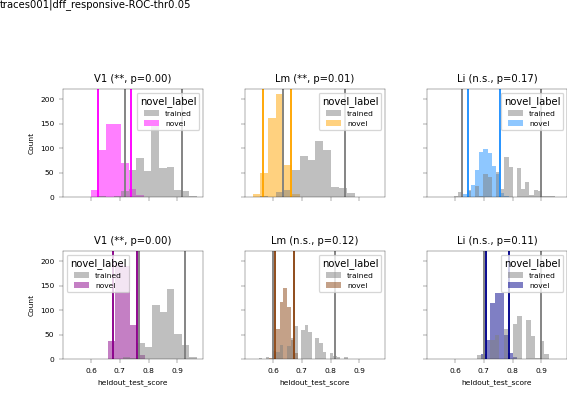

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs distns_95CI_test_trained-v-novel


In [25]:
metric='heldout_test_score'
v1='novel'
v2='trained'
data_['novel_label'] = [v1 if v else v2 for v in data_['novel'].values]
fig, axn = pl.subplots(2,3, figsize=(7,5), sharex=True, sharey=True)

for (va, rf_), vg in data_.groupby(['visual_area', 'rfs']):
    ri=1 if rf_=='matched' else 0
    vi = visual_areas.index(va)
    ax=axn[ri, vi]
    c1 = area_colors2[va] if rf_=='matched' else area_colors[va]
    c2 = [0.5]*3
    sns.histplot(x='heldout_test_score', hue='novel_label', data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)

    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.novel][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)
    c_lo, c_hi = hutils.get_empirical_ci(vg[~(vg.novel)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    # Sig test
    # vg = df_[(df_.visual_area==va) & (df_.rfs=='matched')]
    meas_mean = vg[(vg.novel)]['heldout_test_score'].mean()
    trained_dist = sorted(vg[~(vg.novel)]['heldout_test_score'].values)
    n_below = len(np.where(trained_dist<meas_mean)[0])
    pv = n_below/len(trained_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'

    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv))
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
pplot.label_figure(fig, data_id)

figname = 'distns_95CI_test_trained-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


In [26]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs'

In [27]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

# Is this difference significantly greater than chance?

In [245]:
# data_ = mean_df[(mean_df['n_cells']==max_ncells) 
#             & (mean_df['condition']=='data')].copy().reset_index(drop=True)
data_ = iterdf[(iterdf.n_cells==max_ncells) 
               & (iterdf.condition=='data') & (iterdf.iteration<=200)].copy()

d_list=[]
for rf_cond, data_df in data_.groupby('rfs'):
    diff_ = dec.permutation_test_trained_v_novel(data_df)
    diff_['rfs'] = rf_cond
    d_list.append(diff_.reset_index(drop=True))
diffs = pd.concat(d_list, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


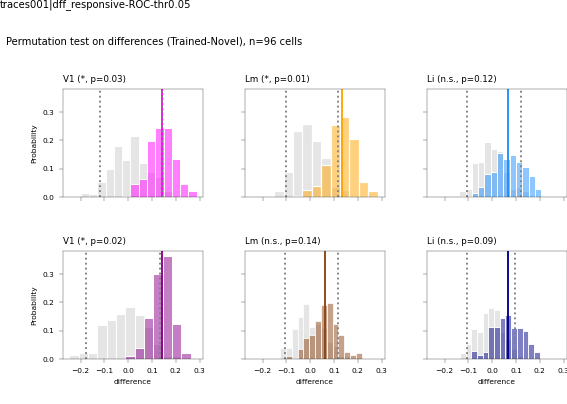

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs permutation_test_trained-v-novel-diffs


In [246]:
shuff_color=[0.8]*3

fig, axn = pl.subplots(2,3, figsize=(7,5), sharex=True, sharey=True)

for (va, rf_), vg in diffs.groupby(['visual_area', 'rfs']):
    ri=1 if rf_=='matched' else 0
    vi = visual_areas.index(va)
    ax=axn[ri, vi]

    curr_colors= area_colors2.copy() if rf_=='matched' else area_colors.copy()
    sns.histplot(x='difference', hue='trained_v_novel', data=vg, ax=ax, alpha=0.5,
                palette={'shuffled': shuff_color, 'true': curr_colors[va]},
                stat='probability', legend=True, common_norm=False,
                edgecolor='w')
    
    meas_mean = vg[vg.trained_v_novel=='true']['difference'].mean()
    ax.axvline(x=meas_mean, color=curr_colors[va])
    shuff_dist = sorted(vg[vg.trained_v_novel=='shuffled']['difference'].values)
    n_extreme = len(np.where(shuff_dist>=meas_mean)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv), loc='left', fontsize=7)
    
    c_lo, c_hi = hutils.get_empirical_ci(shuff_dist)
    ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
    ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    if ri==0 and va=='Li':
        leg_h = pplot.custom_legend_markers(colors=[[0.5]*3, shuff_color],
                                           labels=['true', 'shuffled'], 
                                           use_patch=True)
        ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=None)
    else:
        ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
fig.text(0.01, 0.9,\
         "Permutation test on differences (Trained-Novel), n=%i cells" \
         % max_ncells, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'permutation_test_trained-v-novel-diffs'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [247]:
diffs[diffs.trained_v_novel=='true'].groupby(['visual_area', 'rfs'])['difference'].describe()

count      mean       std       min       25%       50%  \
visual_area rfs                                                                
Li          all      201.0  0.067390  0.064461 -0.138158  0.022980  0.071633   
            matched  201.0  0.065131  0.061408 -0.089474  0.019737  0.064474   
Lm          all      201.0  0.131864  0.056558 -0.050575  0.098276  0.135920   
            matched  201.0  0.063131  0.055434 -0.100862  0.028736  0.064655   
V1          all      201.0  0.139887  0.052634  0.006322  0.104885  0.140230   
            matched  201.0  0.140080  0.044112 -0.007759  0.112356  0.145115   

                          75%       max  
visual_area rfs                          
Li          all      0.113552  0.205387  
            matched  0.113158  0.198684  
Lm          all      0.170115  0.282471  
            matched  0.096264  0.215517  
V1          all      0.174138  0.287069  
            matched  0.172414  0.262356

In [248]:
# data_ = iterdf[(iterdf.n_cells==max_ncells) & (iterdf.condition=='data')].copy()
data_ = iterdf[(iterdf.n_cells==max_ncells) 
               & (iterdf.condition=='data') & (iterdf.iteration<=200)].copy()

# d_list=[]
# for rf_cond, data_df in data_.groupby('rfs'):
#     diff_ = dec.permutation_test_trained_v_novel(data_df)
#     diff_['rfs'] = rf_cond
#     d_list.append(diff_.reset_index(drop=True))
# diffs = pd.concat(d_list, axis=0, ignore_index=True)
d_list=[]
for rf_cond, data_df in data_.groupby('rfs'):
    data_scores = dec.average_within_iterations_by_ncells(data_df, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'condition', 'iteration'])
    true_ = dec.calculate_difference_scores(data_scores)
    true_['rfs'] = rf_cond
    d_list.append(true_.reset_index(drop=True))
diff_scores = pd.concat(d_list, axis=0, ignore_index=True)
diff_scores.head()

,visual_area,n_cells,iteration,difference,rfs
0,Li,96,0,-1.110223e-16,all
1,Lm,96,0,1.238506e-01,all
2,V1,96,0,4.252874e-02,all
3,Li,96,1,6.710526e-02,all
4,Lm,96,1,1.488506e-01,all


<IPython.core.display.Javascript object>


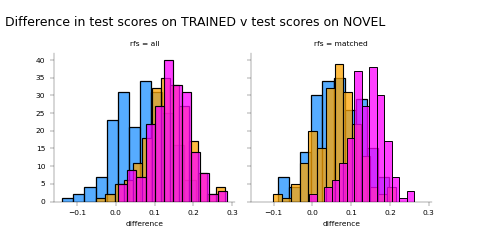

Text(0.01, 0.9, 'Difference in test scores on TRAINED v test scores on NOVEL')

In [249]:
#fig, axn = pl.subplots(1, 2, figsize=(6,3))
#ax=axn[0]

fg = sns.FacetGrid(col='rfs', data=diff_scores, height=3, 
                  hue='visual_area', palette=area_colors)
fg.map(sns.histplot, 'difference')

# sns.histplot(x='difference', data=true_diffs[true_diffs], ax=ax,
#              hue='visual_area', palette=area_colors)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8)
fg.fig.text(0.01, 0.9, 'Difference in test scores on TRAINED v test scores on NOVEL')

In [134]:
import pingouin as pg

In [250]:
a = diff_scores[diff_scores.visual_area==v1]['difference'] #.dropna().values
b = diff_scores[diff_scores.visual_area==v2]['difference'] #.dropna().values
pg.mwu(a, b)


,U-val,tail,p-val,RBC,CLES
MWU,101975.0,two-sided,1.272548e-10,-0.262036,0.631018


In [251]:
a

1       0.123851
4       0.148851
7       0.154598
10     -0.021552
13      0.138218
          ...   
1192   -0.015805
1195    0.028736
1198    0.083046
1201    0.081897
1204    0.092816
Name: difference, Length: 402, dtype: float64

In [252]:
v1='Li'
v2='V1'
curr_areas = [v1, v2]
df_ = data_[(data_.visual_area.isin(curr_areas))
                & (data_.rfs=='all')].copy()

d_list=[]

data_scores = dec.average_within_iterations_by_ncells(df_, 
                                analysis_type='by_ncells',
                                test_type='size_single',
                                grouper=['visual_area', 'condition', 'iteration'])
true_ = dec.calculate_difference_scores(data_scores)
true_['labels'] = 'true'

# shuff0 = df_.copy()
# shuff0['visual_area'] = shuff0.groupby(\
#                             ['iteration', 'train_transform', 'novel'])['visual_area']\
#                             .transform(np.random.permutation)
# shuff_scores = dec.average_within_iterations_by_ncells(shuff0, 
#                                 analysis_type='by_ncells',
#                                 test_type='size_single',
#                                 grouper=['visual_area', 'condition', 'iteration'])
# shuff_ = dec.calculate_difference_scores(shuff_scores)
# shuff_['labels'] = 'shuffled'
# diff_scores = pd.concat([true_, shuff_], axis=0, ignore_index=True)


In [253]:
score_list=[]
for rf_cond, df_ in data_.groupby(['rfs']):
    byiter = dec.average_within_iterations_by_ncells(df_, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'condition', 'iteration'])
    scores_ = dec.calculate_difference_scores(byiter)
    scores_['rfs'] = rf_cond
    score_list.append(scores_)
all_scores0 = pd.concat(score_list, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


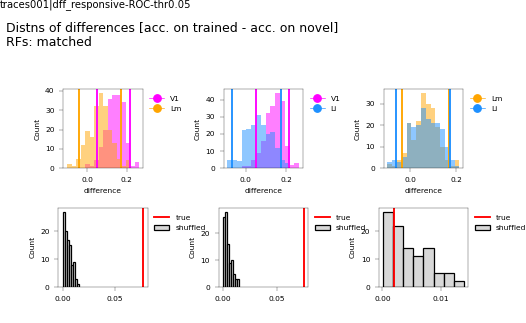

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs compare_by_area_difference_scores_rfs-matched


In [257]:
max_iter=200
n_shuff=100
p_vals = []
metric='difference'
v_combos = list(itertools.combinations(visual_areas, 2))

rfs_cond='matched'
all_scores = all_scores0[all_scores0.rfs==rfs_cond].copy()

fig, axn = pl.subplots(2, len(v_combos), figsize=(6.5,4))
for ai, (v1, v2) in enumerate(v_combos):
    v_list = [v1, v2]
    a_ = all_scores[all_scores.visual_area==v1][metric]
    b_ = all_scores[all_scores.visual_area==v2][metric]
    true_ = abs(a_.mean() - b_.mean())

    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(n_shuff):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:max_iter])
        v = np.mean(combined_[max_iter:])
        diff_s = abs(i-v)
        shuff_.append(diff_s)
    shuff = np.array(shuff_)
    pv_ = len(np.where(shuff>=true_)[0])/n_shuff
    p_vals.append(pd.Series({'v1': v1, 'v2': v2, 'p_val': pv_}))
    
    ax=axn[1, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    ax=axn[0, ai]
    c1= area_colors[v1]
    c2 = c2=area_colors[v2]
    sns.histplot(x=metric, hue='visual_area', ax=ax,
                 data=all_scores[all_scores.visual_area.isin(v_list)], 
                 palette={v1:c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(all_scores[all_scores.visual_area==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(all_scores[all_scores.visual_area==v2][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.75, wspace=0.8, hspace=0.5)
fig.text(0.01, 0.87, \
         "Distns of differences [acc. on trained - acc. on novel]\nRFs: %s" % rfs_cond)

pplot.label_figure(fig, data_id)
figname = 'compare_by_area_difference_scores_rfs-%s' % rfs_cond
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [255]:
p_vals

[v1        V1
 v2        Lm
 p_val    0.0
 dtype: object,
 v1        V1
 v2        Li
 p_val    0.0
 dtype: object,
 v1        Lm
 v2        Li
 p_val    0.0
 dtype: object]

In [241]:
pval_df = pd.concat(p_vals, axis=1).T
pval_df['p_val'] = pval_df['p_val'].astype(float)
pval_df

,v1,v2,p_val
0,V1,Lm,0.000
1,V1,Li,0.000
2,Lm,Li,0.968


In [239]:
reject, pvals_corr = pg.multicomp(pval_df['p_val'].values, method='bonf')
print(reject, pvals_corr)

[False  True  True] [0.096 0.    0.   ]


In [216]:
v1 ='Li'
v2 = 'V1'
a = all_scores[all_scores.visual_area==v1]['difference'].values
b =  all_scores[all_scores.visual_area==v2]['difference'].values

n_extreme = len(np.where(a>=b)[0])
pv = n_extreme/len(shuff_diff_scores)
print(pv, n_extreme)

0.194 97


<IPython.core.display.Javascript object>


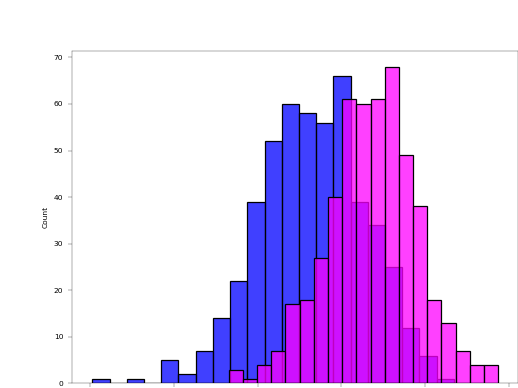

<AxesSubplot:ylabel='Count'>

In [217]:
fig, ax = pl.subplots()
sns.histplot(a, color='blue', ax=ax)
sns.histplot(b, color='magenta', ax=ax)

In [225]:
v1='V1'
v2='Lm'
curr_areas = [v1, v2]
df_ = all_scores[(all_scores.visual_area.isin(curr_areas))].copy()
# df_['difference_abs'] = df_['difference'].abs()
#diff_in_diffscore = df_
mean1 = df_[df_.visual_area==v1]['difference'].mean()
mean2 = df_[df_.visual_area==v2]['difference'].mean()
meas_diff = (mean1-mean2)
# true_diff_scores = (df_[df_.visual_area==v1]['difference'].values \
#                         - df_[df_.visual_area==v2]['difference'].values)
# meas_diff
meas_diff

0.007283333333333308

In [226]:
# df_['visual_area'] = df_.groupby(['iteration'])['visual_area'].transform(np.random.permutation)

In [227]:
# df_['visual_area'] = df_['visual_area'].sample(frac=1).values
# shuff_diff_scores = (df_[df_.visual_area==v1]['difference'].values \
#                         - df_[df_.visual_area==v2]['difference'].values)

In [228]:
n_iters = 500
shuff_diff_scores = []
for i in range(n_iters):
    randi = np.random.randint(0, 1000)
    df_['visual_area'] = df_['visual_area'].sample(frac=1, random_state=randi).values
    mean1 = df_[df_.visual_area==v1]['difference'].mean()
    mean2 = df_[df_.visual_area==v2]['difference'].mean()
    diff_ = (mean1-mean2)
    shuff_diff_scores.append(diff_)
               

<IPython.core.display.Javascript object>


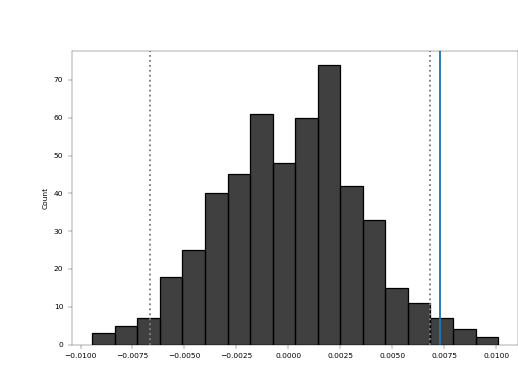

0.02


In [229]:
fig, ax = pl.subplots()
sns.histplot(shuff_diff_scores, color='k')
#sns.histplot(true_diff_scores, color='r')

c_lo, c_hi = hutils.get_empirical_ci(shuff_diff_scores)
ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    
ax.axvline(x=meas_diff)
pl.subplots_adjust(bottom=0.2)

n_extreme = len(np.where(shuff_diff_scores>=meas_diff)[0])
pv = n_extreme/len(shuff_diff_scores)
print(pv)


0.024


<IPython.core.display.Javascript object>


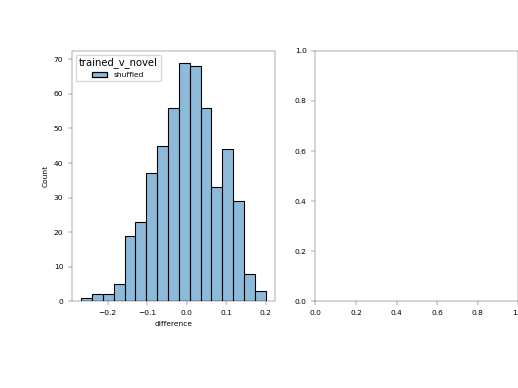

In [83]:
vg = diffs[(diffs.visual_area=='V1') & (diffs.rfs=='matched')
          & (vg.trained_v_novel=='shuffled')].copy()
vg[vg.trained_v_novel=='shuffled']
fig, axn = pl.subplots(1,2)
ax=axn[0]
sns.histplot(x='difference', data=vg, hue='trained_v_novel', ax=ax)
pl.subplots_adjust(bottom=0.3)

In [126]:
vg.groupby(['rfs', 'trained_v_novel']).count()

visual_area  n_cells  iteration  difference
rfs     trained_v_novel                                             
matched shuffled                 500      500        500         500
        true                     500      500        500         500

In [127]:
vg[vg.trained_v_novel=='shuffled']

,visual_area,n_cells,iteration,difference,trained_v_novel,rfs
4502,V1,96,0,-0.085057,shuffled,matched
4505,V1,96,1,0.172989,shuffled,matched
4508,V1,96,2,0.186782,shuffled,matched
4511,V1,96,3,0.011494,shuffled,matched
4514,V1,96,4,-0.101149,shuffled,matched
...,...,...,...,...,...,...
5987,V1,96,495,-0.133908,shuffled,matched
5990,V1,96,496,-0.148276,shuffled,matched
5993,V1,96,497,-0.121264,shuffled,matched
5996,V1,96,498,-0.139655,shuffled,matched


<IPython.core.display.Javascript object>


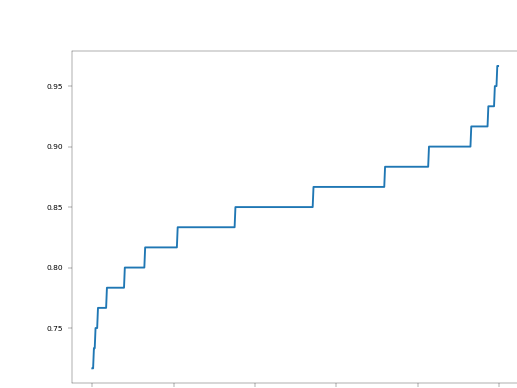

In [75]:
pl.figure()
pl.plot(vg[~(vg.novel)].sort_values(by='heldout_test_score')['heldout_test_score'].values)


In [32]:
data_df = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]


In [33]:
data_df.groupby(['visual_area', 'rfs', 'novel']).count()

condition  iteration  n_cells  fit_time  \
visual_area rfs     novel                                            
Li          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
Lm          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
V1          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   

                           score_time  test_score  train_score  \
visual_area rfs     novel                                        
Li          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
Lm          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
V1          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   

                           heldout_test_score    C  randi  train_transform  \
visual_area rfs     novel                                                    
Li          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
Lm          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
V1          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   

                           test_transform  n_trials  randi_cells  intact  \
visual_area rfs     novel                                                  
Li          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
Lm          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
V1          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              50

In [36]:
d_list=[]
for (va, rf_cond), cg in data_df.sort_values(by='iteration')\
                .groupby(['visual_area', 'rfs']):
    novel_scores = cg[cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    trained_scores = cg[~cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    diffs = trained_scores - novel_scores
    df_ = pd.DataFrame({'trained_minus_novel': diffs})
    df_['visual_area'] = va
    df_['condition'] = 'data'
    df_['rfs'] = rf_cond
    df_['iteration'] = cg[cg.novel].sort_values(by='iteration')['iteration'].values
    d_list.append(df_)
diffdf = pd.concat(d_list, axis=0)

<IPython.core.display.Javascript object>


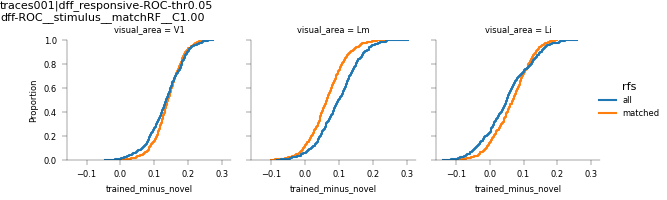

In [37]:
# fig, ax = pl.subplots()
g = sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='ecdf', 
           )
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(g.fig, '%s\n%s' % (data_id, aggr_id))

figname = 'diff_trained-minus-novel_matchrf-v-all'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


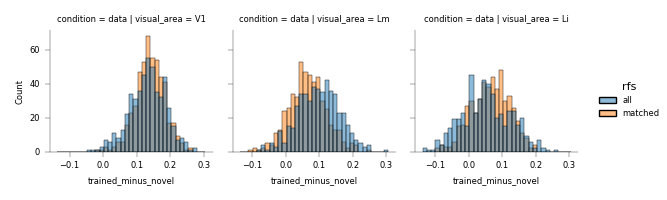

In [38]:
sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='hist', row='condition'
           )

<IPython.core.display.Javascript object>


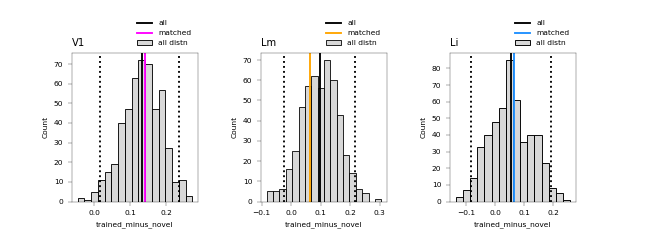

In [50]:
metric='trained_minus_novel'
fig, axn = pl.subplots(1,3, figsize=(8,3))

for va, vg in diffdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x=metric, data=vg[vg['rfs']=='all'], ax=ax,
            color=[0.8]*3, label='all distn')
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg['rfs']=='all'][metric].values, ci=0.95)
    ax.axvline(x=c_lo, color='k', ls=':')
    ax.axvline(x=c_hi, color='k', ls=':')
    mean_v0 = vg[vg['rfs']=='all'][metric].mean()
    ax.axvline(x=mean_v0, color='k', label='all')
    
    # sns.histplot(x='trained_minus_novel', data=plotd[plotd['rfs']=='matched'], ax=ax)
    mean_v = vg[vg['rfs']=='matched'][metric].mean()
    ax.axvline(x=mean_v, color=area_colors[va], label='matched')
    ax.set_title(va, loc='left')
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False)
    
pl.subplots_adjust(bottom=0.25, right=0.8, left=0.1, wspace=0.5, top=0.8)

In [51]:
df_ = diffdf[(diffdf['condition']=='data')].copy()
df_.groupby(['visual_area', 'rfs']).count()

trained_minus_novel  condition  iteration
visual_area rfs                                               
Li          all                      500        500        500
            matched                  500        500        500
Lm          all                      500        500        500
            matched                  500        500        500
V1          all                      500        500        500
            matched                  500        500        500

<IPython.core.display.Javascript object>


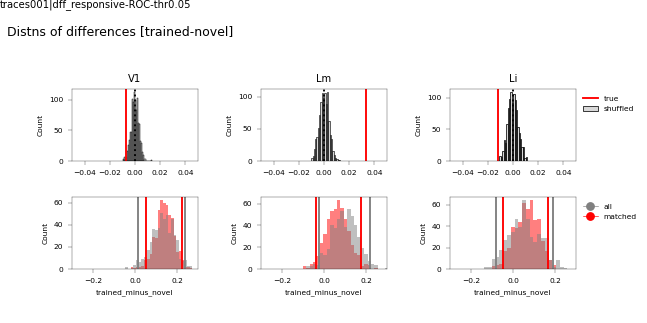

1.0
0.0


No handles with labels found to put in legend.


0.0
1.0
0.985
0.015
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls shuffle_test_DIFF_distn


In [61]:
v1='all'
v2='matched'
c1=[0.5]*3
c2='r'
fig, axn = pl.subplots(2, 3, figsize=(8,4))
for va, vg in diffdf.groupby(['visual_area']):
    # Shuffle test
    a_ = vg[(vg.rfs=='matched')][metric]
    b_ = vg[(vg.rfs=='all')][metric]
    true_ = b_.mean() - a_.mean()
    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(1000):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:500])
        v = np.mean(combined_[500:])
        shuff_.append(i-v)
    shuff = np.array(shuff_)

    ai = visual_areas.index(va)
    ax=axn[0, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    print(len(np.where(shuff>true_)[0])/1000.)
    print(len(np.where(shuff<true_)[0])/1000.)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    ax.set_xlim([-0.05, 0.05])
    ax.axvline(x=0, color='k', ls=':')

    ax.set_title(va)
    
    # Plot original distns with CI
    ax=axn[1, ai]
    sns.histplot(x=metric, hue='rfs', data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.rfs==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(vg[(vg.rfs==v2)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    ax.set_xlim([-0.3, 0.3])
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()

ax=axn[0, 2]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax=axn[1,2]
leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.75, wspace=0.5, hspace=0.5)
fig.text(0.01, 0.9, "Distns of differences [trained-novel]")

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25)

pplot.label_figure(fig, data_id)

figname = 'shuffle_test_DIFF_distn'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


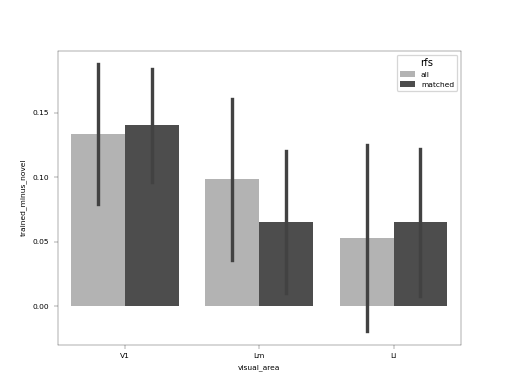

In [70]:
rfmatch_colors={'all': [0.7]*3, 'matched': [0.3]*3}
fig, ax = pl.subplots()

sns.barplot(x='visual_area', y='trained_minus_novel', data=diffdf, ax=ax,
           hue='rfs', palette=rfmatch_colors, order=visual_areas, ci='sd')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2)